# 目的
キックスタータープロジェクトが、成功するのか失敗するのか予想するモデル作成を目的とする。<br>
https://www.kaggle.com/kemical/kickstarter-projects

データは、ks-projects-201801.csv

目的変数は、state

予想するのは、failed もしくは successful の２値のみで、その他は無視する

# ライブラリ・データのインポート

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection 
import sklearn.preprocessing
import sklearn.svm
import sklearn.tree

In [2]:
df = pd.read_csv("ks-projects-201801.csv", parse_dates=True)

# データの説明

Jupyter Notebook では、なぜか右寄せになってしまう

| 列名 | 説明 | 要不要 |
| :--- | :--- | :--- |
| ID            | 内部ID           | 不要 |
| name          | プロジェクト名   | 必要。例えば、現れる単語によって、成功率が変わるかもしれない |
| category      | サブカテゴリ     | 必要 |
| main_category | メインカテゴリ   | 必要 |
| currency      | 通貨名           | 必要 |
| deadline      | 終了日           | 必要 |
| goal          | 目標金額         | 通貨の単位がマチマチなので使えない |
| launched      | 開始日           | 必要 |
| pledged       | 実際に集まった額 | 不要 (目的変数) |
| state         | プロジェクトの現状 | 目的変数 |
| backers       | パトロンの人数   | 不要 (目的変数) |
| country       | 国名             | 必要 |
| usd pledged   | US＄で集まった額？ | 不要 (目的変数) |
| usd_pledged_real | US＄換算のpledged？ | 不要 (目的変数) |
| usd_goal_real | US＄換算のgoal？ | 必要 |

In [3]:
#df.head()
#df.info()
#df.describe(include='all')

# 目標
本来は、全 378,661 件中 46,986 件はその他に分類されるはずなので、精度は最大でも 87.6% 程度となる

今回は、残り 331,675 件のデータを前提として考える

この時、全て failed と予想するモデルを考えると、Accuracy(正解率)は 59.612% となる

よって、この正解率を超えるモデルの作成を目標とする

In [4]:
# successful, failed, その他の件数
df.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

# 目的変数について
state 列に false:failed もしくは true:successful を代入する

state2 列は 0:failed もしくは 1:successful を代入する<br>
これは成功率を算出しやすくするための一時変数であり、最終的には消す

In [5]:
# failed or successful のみとする
df = df[df['state'].isin(['failed','successful'])]
df["state"] = df["state"]=="successful"

# state2 = 0:faled, 1:successful
df["state2"] = 0
df.loc[df.state, "state2"] = 1

# 各説明変数と成功率のグラフ (重要度：高？)
name.len（nameの文字数）を見ると、文字数が多いほうが成功率が高い

name.words（スペースの数。英文はスペース区切りなので、通常は「スペースの数＋１＝単語数」となるはず）は、5～15単語の成功率が高い。

launched.year, deadline.year は、年を追うごとに失敗率が上がっている

days（deadline と launched の差(日数)）は、期間が短い方が成功率が高い

usd_goal_real.log2 (小縣先生のアドバイスを参考に対数化) は、金額が小さいほど成功率が高いことが分かる

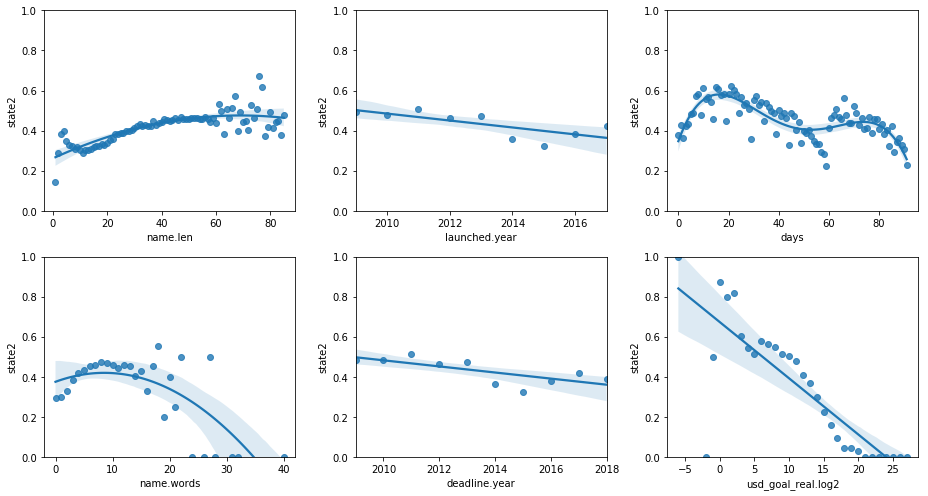

In [6]:
# datetime 型に変換する
launched = pd.to_datetime(df.launched)
deadline = pd.to_datetime(df.deadline)

# グラフ描画
def sns_regplot(df, ax, name, lx, ly, so=1):
    z = df.groupby(name).state2.mean()
    t = sns.regplot(z.index.array, z.values, order=so, ax=ax)
    t.set_xlabel(lx)
    t.set_ylabel(ly)
    ax.set_ylim(0, 1)

_, ax = plt.subplots(2, 3, figsize=(13,7))

df["name.len"] = df.name.str.len()
sns_regplot(df, ax[0,0], "name.len", "name.len", "state2", so=2)
df["name.words"] = df.name.str.count(" ")
sns_regplot(df, ax[1,0], "name.words", 'name.words', "state2", so=2)
df["launched.year"] = launched.dt.year
sns_regplot(df, ax[0,1], "launched.year", "launched.year", "state2")
df["deadline.year"] = deadline.dt.year
sns_regplot(df, ax[1,1], "deadline.year", "deadline.year", "state2")
df["days"] = (deadline - launched).dt.days
sns_regplot(df, ax[0,2], "days", "days", "state2", so=4)
df["usd_goal_real.log2"] = np.log2(df.usd_goal_real).astype(int)
sns_regplot(df, ax[1,2], "usd_goal_real.log2", "usd_goal_real.log2", "state2")

plt.tight_layout()

# 各説明変数と成功率のグラフ (重要度：低？)
こちらは、Y軸のスケールを変更している。成功率への寄与度は低そう。

launched.month, deadline.month は、春秋の成功率が高く、夏冬は低い

launched.day, deadline.day は、月初の成功率が高く、月末は低い

launched.dayofweek, deadline.dayofweek（0:月曜～6:日曜）は、週初めの成功率が高い

C:\Users\TDN09084\AppData\Roaming\Python\Python37\site-packages\seaborn\regression.py:250: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


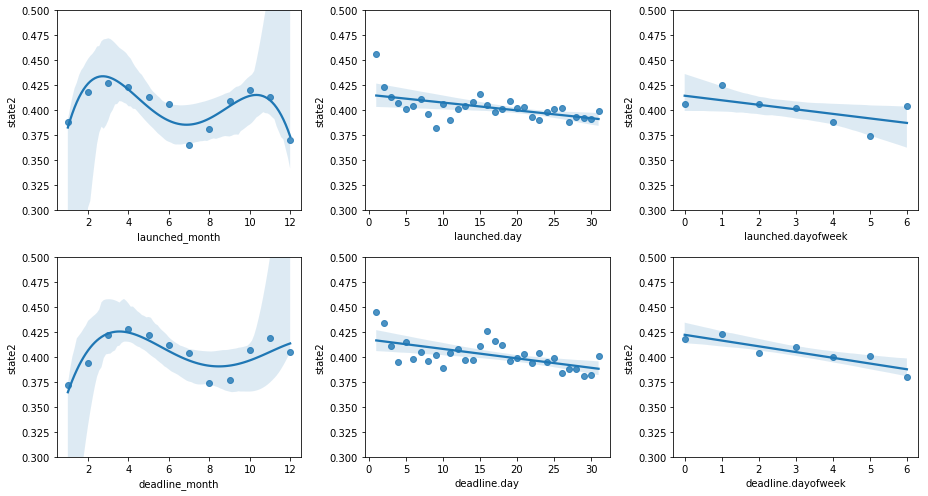

In [7]:
def sns_regplot(df, ax, name, lx, ly, so=1):
    z = df.groupby(name).state2.mean()
    t = sns.regplot(z.index.array, z.values, order=so, ax=ax)
    t.set_xlabel(lx)
    t.set_ylabel(ly)
    ax.set_ylim(0.3, 0.5)

_, ax = plt.subplots(2, 3, figsize=(13,7))
df["launched.month"] = launched.dt.month
sns_regplot(df, ax[0,0], "launched.month", "launched_month", "state2", 4)
df["deadline.month"] = deadline.dt.month
sns_regplot(df, ax[1,0], "deadline.month", "deadline_month", "state2", 4)
df["launched.day"] = launched.dt.day
sns_regplot(df, ax[0,1], "launched.day", "launched.day", "state2")
df["deadline.day"] = deadline.dt.day
sns_regplot(df, ax[1,1], "deadline.day", "deadline.day", "state2")
df["launched.dayofweek"] = launched.dt.dayofweek
sns_regplot(df, ax[0,2], "launched.dayofweek", "launched.dayofweek", "state2", 1)
df["deadline.dayofweek"] = deadline.dt.dayofweek
sns_regplot(df, ax[1,2], "deadline.dayofweek", "deadline.dayofweek", "state2", 1)
plt.tight_layout()

# 各説明変数と成功率のグラフ (文字変数)
横軸は件数 (の対数)、縦軸は成功率である

main_category, category は、件数が増えても平均値に収束するわけではなく、偏りが大きい → 重要な変数？

currency, country は、件数が増えると平均値に収束しそうに見える → あまり重要ではない？

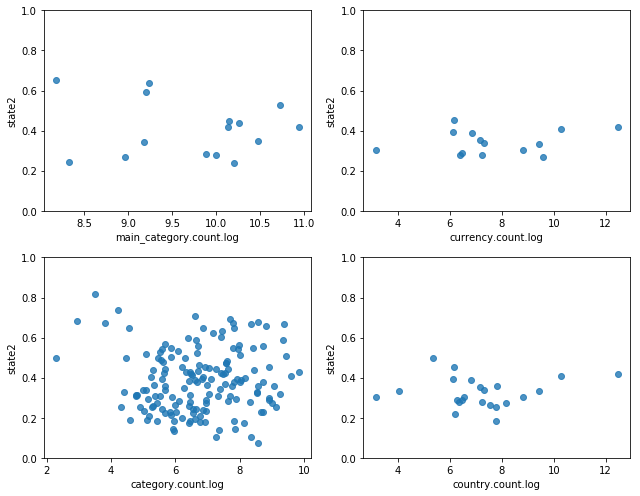

In [8]:
def sns_regplot(df, ax, name, lx, ly, so=1):
    z = df.groupby(name).state2
    t = sns.regplot(np.log(z.count()), z.mean(), ax=ax, fit_reg=False)
    t.set_xlabel(lx)
    t.set_ylabel(ly)
    ax.set_ylim(0, 1)

_, ax = plt.subplots(2, 2, figsize=(9,7))
sns_regplot(df, ax[0,0], "main_category", "main_category.count.log", "state2")
sns_regplot(df, ax[1,0], "category"     , "category.count.log"     , "state2")
sns_regplot(df, ax[0,1], "currency"     , "currency.count.log"     , "state2")
sns_regplot(df, ax[1,1], "country"      , "country.count.log"      , "state2")
plt.tight_layout()

# 文字変数の変換
木モデル用に変換する

ロジスティック回帰などは、後ほど Target Encording を用いて変換したものを使用する

In [9]:
le = sklearn.preprocessing.LabelEncoder()
df["main_category.label"] = le.fit_transform(df.main_category)
df["category.label"]      = le.fit_transform(df.category)
df["currency.label"]      = le.fit_transform(df.currency)
df["country.label"]       = le.fit_transform(df.country)

## 欠損値の対応
usd pledged は使用しないので、無視する

name.len と name.words は、元々長さ０の文字列だったものが null としてカウントされているだけなので、今回は０埋めする

In [10]:
df.isnull().sum()

ID                       0
name                     3
category                 0
main_category            0
currency                 0
deadline                 0
goal                     0
launched                 0
pledged                  0
state                    0
backers                  0
country                  0
usd pledged            210
usd_pledged_real         0
usd_goal_real            0
state2                   0
name.len                 3
name.words               3
launched.year            0
deadline.year            0
days                     0
usd_goal_real.log2       0
launched.month           0
deadline.month           0
launched.day             0
deadline.day             0
launched.dayofweek       0
deadline.dayofweek       0
main_category.label      0
category.label           0
currency.label           0
country.label            0
dtype: int64

In [11]:
df = df.fillna(0)

# 前処理について

通常、カテゴリ変数をダミー変数に置き換える場合は get_dummies の様な事を行うと思うが、ここでは思いつきを試している。

> Target Encording と言うようだ (小林宏明さんより）<br>
以下の実装は Greedy TS に当たるようで、リークが発生してる<br>
データが少ない場合は影響が大きくなり過学習に陥るはずなので、注意すること<br>

get_dummies と比べて説明変数が少なくなるので、処理の高速化が期待できる一方で、性能は悪くなるのではないかと思う<br>
今回は get_dummies との比較は行っていないので、効果の程は不明

# 汎化性能の評価方法

データ数は多い（と思う）ので、ホールドアウト法を用いる<br>
今回は、学習データとテストデータの比率は ８：２ とする<br>
交差検証（クロスバリデーション）法は用いていない

In [12]:
# X_train[dest] もしくは X_test[dest] に、「X_train[src] の成功率」を代入する
def f_set_mean(X_train, X_test, src, dest):

    mean_train = X_train.groupby(src).state2.mean()
    X_train[dest] = 0
    X_test [dest] = 0
    for n in mean_train.index:
        X_train.loc[X_train[src]==n, dest] = mean_train[n]
        X_test .loc[X_test [src]==n, dest] = mean_train[n]

# 説明変数・目的変数
y = df["state"].values
X = df.drop(columns=['ID', 'name', 'deadline', 'goal', 'launched', 'pledged', 'state', 'backers', 'usd pledged', 'usd_pledged_real'])

# ホールドアウト法 で train と test に分割する
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=1234)

# 更に数値を加工するので、コピーしておく
X_train = X_train.copy()
X_test = X_test.copy()

f_set_mean(X_train, X_test, "main_category", "main_category.GreedyTS") # main_category.GreedyTS = main_category の成功率 (X_train基準)
f_set_mean(X_train, X_test, "category"     , "category.GreedyTS"     ) # category (上と同様)
f_set_mean(X_train, X_test, "currency"     , "currency.GreedyTS"     ) # currency (上と同様)
f_set_mean(X_train, X_test, "country"      , "country.GreedyTS"      ) # country (上と同様)

# 必要な列のみに絞り込む
X_train = X_train.drop(columns=['category', 'main_category', 'currency', 'country', 'state2'])
X_test  = X_test .drop(columns=['category', 'main_category', 'currency', 'country', 'state2'])

print("最終的な説明変数")
print(X_train.info())

# 標準化する (X_train基準)
stdsc   = sklearn.preprocessing.StandardScaler()
X_train = stdsc.fit_transform(X_train.values)
X_test  = stdsc.transform(X_test.values)

最終的な説明変数
<class 'pandas.core.frame.DataFrame'>
Int64Index: 265340 entries, 289768 to 188585
Data columns (total 21 columns):
usd_goal_real             265340 non-null float64
name.len                  265340 non-null float64
name.words                265340 non-null float64
launched.year             265340 non-null int64
deadline.year             265340 non-null int64
days                      265340 non-null int64
usd_goal_real.log2        265340 non-null int32
launched.month            265340 non-null int64
deadline.month            265340 non-null int64
launched.day              265340 non-null int64
deadline.day              265340 non-null int64
launched.dayofweek        265340 non-null int64
deadline.dayofweek        265340 non-null int64
main_category.label       265340 non-null int32
category.label            265340 non-null int32
currency.label            265340 non-null int32
country.label             265340 non-null int32
main_category.GreedyTS    265340 non-null float64
cat

# ロジスティック回帰の場合

正解率(Accuracy) は学習/テストともに大差ないので、過学習ではないと思われる

当てずっぽうより 7.883 ポイント性能が高い

In [13]:
clf = sklearn.linear_model.SGDClassifier(loss='log', penalty='none', max_iter=1000, tol=1e-3, random_state=1234)
clf.fit(X_train, y_train)
print(f"正答率(Accuracy) = 学習 {clf.score(X_train, y_train):.3%} / テスト {clf.score(X_test, y_test):.3%}")

正答率(Accuracy) = 学習 67.491% / テスト 67.494%


## サポートベクターマシンの場合
途中計算は省いているが、GridSearchCV を用いてハイパーパラメータの探索を行った<br>
GridSearchCV の cv は探索段階では 2、最終的には 5 とした<br>
SVC の kernel=linear/rbf, C=0.1～100 を適当に試して、最終的に kernel=rbf, C=1.3 とした

なお、学習に要する時間を省くため、学習に用いるデータ量を探索段階では 5%、最終段階でもは 15% に絞っている

正解率(Accuracy) は学習/テストに 2.146 ポイントの差があるため、過学習かもしれない<br>
よって、学習に用いるデータ量を増やすべきかもしれない

In [14]:
def f_SVC(X_train, X_test, y_train, y_test, parameters, train_size, cv):
    # 学習データを更に割り引く (遅いので)
    X_temp, _, y_temp, _ = sklearn.model_selection.train_test_split(X_train, y_train, test_size=1-train_size, random_state=1234)
    # SVCで学習する (GridSearchしている)
    model = sklearn.svm.SVC(gamma="scale", random_state=1234)
    clf = sklearn.model_selection.GridSearchCV(model, parameters, n_jobs=-1, return_train_score=False, cv=cv)
    clf.fit(X_temp, y_temp)
    print(f"best_params = {clf.best_params_} / best_score = {clf.best_score_}")
    print(f"正答率(Accuracy) = 学習 {clf.score(X_temp, y_temp):.3%} / テスト {clf.score(X_test, y_test):.3%}")

In [15]:
parameters = {'kernel':['rbf'], 'C':[1.3]}
f_SVC(X_train, X_test, y_train, y_test, parameters, train_size=0.15, cv=5)

best_params = {'C': 1.3, 'kernel': 'rbf'} / best_score = 0.6751337906082762
正答率(Accuracy) = 学習 70.222% / テスト 68.076%


# ランダムフォレストの場合
途中計算は省いているが、GridSearchCV を用いてハイパーパラメータの探索を行った<br>
RandomForestClassifier の n_estimators は探索段階では 2、最終的には 100 とした<br>
max_depth, min_samples_leaf, min_samples_split は 1～100 辺りを試して、最終的には 14, 17, 47 とした

In [16]:
def f_RandomForest(X_train, X_test, y_train, y_test, parameters, cv, n_est):
    model = sklearn.ensemble.RandomForestClassifier(criterion="gini", n_estimators=n_est, random_state=1234)
    clf = sklearn.model_selection.GridSearchCV(model, parameters, cv=cv, n_jobs=-1, return_train_score=False)
    clf.fit(X_train, y_train)
    print(f"best_params = {clf.best_params_} / best_score = {clf.best_score_}")
    print(f"正答率(Accuracy) = 学習 {clf.score(X_train, y_train):.3%} / テスト {clf.score(X_test, y_test):.3%}")

In [17]:
parameters = {'max_depth':[14], 'min_samples_leaf':[17], 'min_samples_split':[47]}
f_RandomForest(X_train, X_test, y_train, y_test, parameters, cv=2, n_est=100)

best_params = {'max_depth': 14, 'min_samples_leaf': 17, 'min_samples_split': 47} / best_score = 0.6913733323283334
正答率(Accuracy) = 学習 71.938% / テスト 69.343%


# 決定木（アダブースト）の場合
途中計算は省いているが、ハイパーパラメータの探索を行っている<br>
AdaBoostClassifier の n_estimators は 探索も最終段階も 3 とした<br>
DecisionTreeClassifier の max_depth, min_samples_leaf, min_samples_split は 1～100 辺りを試して、最終的には 9, 25, 65 とした

In [18]:
def f_abdt(md, msl, mss, ne):
    model = sklearn.tree.DecisionTreeClassifier(max_depth=md, min_samples_leaf=msl, min_samples_split=mss, random_state=1234, criterion="gini")
    clf = sklearn.ensemble.AdaBoostClassifier(model, n_estimators=ne, random_state=1234)
    clf.fit(X_train, y_train)
    print(f"正答率(Accuracy) = 学習 {clf.score(X_train, y_train):.3%} / テスト {clf.score(X_test, y_test):.3%}")

In [19]:
for max_depth in [9]:
    for min_samples_leaf in [25]:
        for min_samples_split in [65]:
            for n_estimators in [3]:
                print(f"max_depth = {max_depth}, min_leaf = {min_samples_leaf}, min_split = {min_samples_split}, n_est = {n_estimators}")
                f_abdt(max_depth, min_samples_leaf, min_samples_split, n_estimators)

max_depth = 9, min_leaf = 25, min_split = 65, n_est = 3
正答率(Accuracy) = 学習 69.954% / テスト 68.793%


# ニューラルネットワークの場合

自由度が高くて、どのようにモデルを組み立てるか、非常に困った

とりあえず、21変数 → 210ノード → relu → 100ノード → relu → 1ノード → sigmoid とした。

あまり試せておらず、詰めが甘いと思う

In [20]:
import tensorflow.compat.v1.keras
import tensorflow.compat.v1.keras.layers

model = tensorflow.compat.v1.keras.Sequential()
model.add(tensorflow.compat.v1.keras.layers.Dense(210, activation='relu', input_dim=21))
model.add(tensorflow.compat.v1.keras.layers.Dense(100, activation='relu', input_dim=210))
model.add(tensorflow.compat.v1.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="rmsprop", metrics=['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [21]:
fit = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

y_est = model.predict(X_train)
y_est = np.round(y_est).astype(int)
print(f"正答率(Accuracy) = 学習 {sklearn.metrics.accuracy_score(y_train, y_est):.3%}")

y_est = model.predict(X_test)
y_est = np.round(y_est).astype(int)
print(f"正答率(Accuracy) = テスト {sklearn.metrics.accuracy_score(y_test, y_est):.3%}")

Train on 265340 samples, validate on 66335 samples
Epoch 1/10
265340/265340 [==============================] - 18s 69us/sample - loss: 0.5885 - acc: 0.6795 - val_loss: 0.5828 - val_acc: 0.6844
Epoch 2/10
265340/265340 [==============================] - 18s 67us/sample - loss: 0.5820 - acc: 0.6860 - val_loss: 0.5816 - val_acc: 0.6855
Epoch 3/10
265340/265340 [==============================] - 18s 66us/sample - loss: 0.5788 - acc: 0.6887 - val_loss: 0.5790 - val_acc: 0.6877
Epoch 4/10
265340/265340 [==============================] - 18s 69us/sample - loss: 0.5770 - acc: 0.6903 - val_loss: 0.5784 - val_acc: 0.6883
Epoch 5/10
265340/265340 [==============================] - 19s 72us/sample - loss: 0.5753 - acc: 0.6913 - val_loss: 0.5765 - val_acc: 0.6892
Epoch 6/10
265340/265340 [==============================] - 19s 72us/sample - loss: 0.5741 - acc: 0.6925 - val_loss: 0.5772 - val_acc: 0.6898
Epoch 7/10
265340/265340 [==============================] - 19s 71us/sample - loss: 0.5731 - acc:

# まとめ１

各モデルと、正答率(Accuracy) は以下の通りとなった。

| 順位 | モデル | 学習 | テスト |
| :---: | :--- | :--- | :--- |
| 1 | ランダムフォレスト | 71.938% | 69.343% |
| 2 | ニューラルネットワーク | 69.944% | 69.154% |
| 3 | 決定木（アダブースト）| 69.954% | 68.793% |
| 4 | サポートベクターマシン | 70.222% | 68.076% |
| 5 | ロジスティック回帰 | 67.491% | 67.494% |

１位：ランダムフォレストと、２位：ニューラルネットワークの差は、0.189ポイントである<br>
ニューラルネットワークは、学習とテストの差が小さいので、こちらを採用するのも悪くないと思う

１位：ランダムフォレストと、５位：ロジスティック回帰の差は、1.849 ポイントである<br>
この差が許容できるのであれば、処理が高速なロジスティック回帰を選ぶのも手であると思った

# 特徴選択 (ステップワイズ法)
本来、この段階で行う作業ではないが、せっかくなので試してみる

今回は全２１列のうち、下位５列を削除してみたところ、正答率(Accuracy)が誤差程度だが改善した

以下の順位をみると、先に述べた「説明変数と成功率のグラフ」で、成功率が高かったものや分散が大きかったものが、やはり上位に来ている

個人的には、name.len や name.words と、思いつきで実装した TargetEncording(GreedyTS) が健闘してくれたようで嬉しい

| 順位 | 説明変数 |
| :---: | :--- |
| 01 | days<br>name.len<br>usd_goal_real<br>usd_goal_real.log2<br>main_category.GreedyTS<br>category.GreedyTS |
| 02 | launched.year |
| 03 | name.words |
| 04 | category.label |
| 05 | launched.day |
| 06 | deadline.day |
| 07 | deadline.month |
| 08 | deadline.year |
| 09 | main_category.label |
| 10 | launched.dayofweek |
| 11 | launched.month |
| - | 以下、不採用 |
| 12 | deadline.dayofweek |
| 13 | currency.GreedyTS |
| 14 | country.GreedyTS |
| 15 | currency.label |
| 16 | country.label |

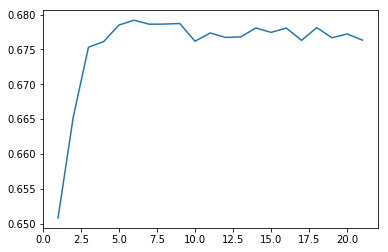

Feature ranking: [ 1  1  3  2  8  1  1 11  7  5  6 10 12  9  4 15 16  1  1 13 14]


In [22]:
from sklearn.feature_selection import RFECV

estimator = sklearn.ensemble.RandomForestClassifier(max_depth=14, min_samples_leaf=17, min_samples_split=47, criterion="gini", n_estimators=3, random_state=1234)

rfecv = RFECV(estimator, cv=2, scoring='accuracy')
rfecv.fit(X_train, y_train)

plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print('Feature ranking:', rfecv.ranking_)

In [23]:
X_train2 = X_train[:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 18]]
X_test2  = X_test [:,[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 18]]

parameters = {'max_depth':[14], 'min_samples_leaf':[17], 'min_samples_split':[47]}
f_RandomForest(X_train2, X_test2, y_train, y_test, parameters, cv=2, n_est=100)

best_params = {'max_depth': 14, 'min_samples_leaf': 17, 'min_samples_split': 47} / best_score = 0.6913356448330444
正答率(Accuracy) = 学習 72.326% / テスト 69.378%


# まとめ２

キックスタータープロジェクトが、成功するのか失敗するのか予想するモデルを作成した

説明変数は以下の１６種類、目的変数は state である

| 説明変数 | - | - | - |
| :--- | :--- | :--- | :--- |
| launched.year      | deadline.year  | main_category.GreedyTS | usd_goal_real      |
| launched.month     | deadline.month | main_category.label    | usd_goal_real.log2 |
| launched.day       | deadline.day   | category.GreedyTS      | name.len           |
| launched.dayofweek | days           | category.label         | name.words         |

モデルの作成には LabelEncoder・標準化・TargetEncording・ランダムフォレスト・特徴選択を用いた<br>
また、汎化性能を推定するために、ホールドアウト法でデータを学習用とテスト用に８：２にわけた

汎化性能として、正答率(Accuracy) = 69.378% を得た<br>
これは当てずっぽうより 9.766 ポイント高い数値であり、目標を達成することができた

# 今後の課題

今回、特徴選択で説明変数の name が重要であるらしい事が分かった<br>

実装が容易な name の「長さ」と「スペースの数」の２種類しか説明変数として用いなかったが、単語に分割して説明変数として使用できれば、違った結果になったのではないかと思う<br>

せめて name を 2-gram (2文字) 単位で分割するぐらいなら実装できそうとも考えたが、前処理も学習も重くなるので採用しなかった<br>
(Ａ～Ｚの２６文字のみに限ると、２６×２６＝６７６変数となる・・・まだ現実的か？？)

# 感想

① 性能が出るモデルの作成は難しいことが分かった<br>
試行する前は８～９割の正答率が出るのかなぁと考えていたが、甘かった<br>
０の段階から目標数値を立てるのは、難しいだろうなと言うように感じた

② 今回はデータの準備を行っていないが、とても大変だろうと思う<br>
説明変数・目的変数になりそうなデータの検討、取得に必要な期間、費用・・・とスタートラインにすら立てない場合もあるだろう<br>
また、今回は大した欠損値がなかったので良かったが、実際はその対応も大変だろう

③ 最初、name は説明変数として使えないと考えていたが、お風呂に入っているときに閃いて、現在の使用法となった。<br>
下手に文字変数をダミー変数に置き換えても次元が増えるだけであったりなど、説明変数を機械学習に適した形に変換するのは、難しい作業であることが分かった。

④ ハイパーパラメータの探索が難しかった。<br>
もちろん時間が無限にあれば最適解が求められるが、限られた時間で「良さそう」な値を求めるだけでも骨が折れる作業だった<br>
まだ計算時間が少ない方だったので、割と手作業が入っても「何とかなった」のだと思う

⑤ 学習を進めれば進めるほど、発展途上であると感じられるようになった<br>
ネットサーフィンをしていても、下のような記事に出会う事がある<br>
https://qiita.com/omiita/items/0049ade809c4817670d7<br>
解きたい問題によっては既存知識でも十分に対応可能だろうし、問題によっては継続的な勉強が必要になるのだろう<br>

⑥ ハードウェア（計算資源）の問題も、また難しい問題である<br>
私の手元のデスクトップＰＣではＣＰＵが古くて、tensorflow が動かなかった<br>
他に、上のURLの内容を試そうと思うと、ＴＰＵが2500台・日も必要らしい<br>
ちょっと試そうと思っても、試すことすら難しい場合もあることが分かった

⑦ ちょっと機械学習をかじると、何でも学習で解こうと考えてしまうようになったので、気をつける<br>
(例：天気予報はシミュレーションでも行う事が可能)

